In [1]:
import pandas as pd
import dask.dataframe as dd

df = dd.read_csv("../VoxelsDataset/ellipsoidVoxels/*").compute().set_index('Unnamed: 0')

In [2]:
X = df.iloc[:,:400]
Y = df.iloc[:,400:]

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.5, random_state = 42)

In [4]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_val = ss.transform(x_val)
x_test = ss.transform(x_test)


In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=50, verbose=1,)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
opt = Adam()

model = Sequential()
model.add(Dense(1000, input_dim=400, kernel_initializer='normal', activation='relu'))
model.add(Dense(1000, kernel_initializer='normal', activation='relu'))
model.add(Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(Dense(1331, kernel_initializer='normal', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], )
model.summary()

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              401000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              2002000   
_________________________________________________________________
dense_4 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              4002000   
______________________

In [6]:
history = model.fit(x=x_train, y=y_train, validation_data = (x_val, y_val), epochs=1000, verbose=1, callbacks=[reduce_lr, early_stop])


=========================] - 21s 8ms/step - loss: 0.0059 - accuracy: 0.9975 - val_loss: 0.0133 - val_accuracy: 0.9952
Epoch 120/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.0104 - accuracy: 0.9961 - val_loss: 0.0102 - val_accuracy: 0.9958
Epoch 121/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.0066 - accuracy: 0.9973 - val_loss: 0.0107 - val_accuracy: 0.9956
Epoch 122/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.0068 - accuracy: 0.9972 - val_loss: 0.0104 - val_accuracy: 0.9958
Epoch 123/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.0066 - accuracy: 0.9973 - val_loss: 0.0100 - val_accuracy: 0.9960
Epoch 124/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0096 - val_accuracy: 0.9962
Epoch 125/1000
2500/2500 [==============================] - 21s 8ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0121 - val_accur

In [7]:
from keras.models import load_model

model.evaluate(x_train, y_train), model.evaluate(x_val, y_val), model.evaluate(x_test, y_test)

5000/5000 [==============================] - 5s 964us/step


([0.0023032509088516235, 0.999123215675354],
 [0.008231164103001357, 0.9968839883804321],
 [0.008327167391777038, 0.9968923926353455])

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
print(accuracy_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))
print(precision_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))
print(recall_score(np.round((model.predict(x_train)*1)).flatten(), np.array(y_train*1).flatten()))

0.999123365890308
0.9978180081272865
0.9969071475440655


In [9]:
print(accuracy_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))
print(precision_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))
print(recall_score(np.round((model.predict(x_val)*1)).flatten(), np.array(y_val*1).flatten()))

0.9968838467317807
0.9911587769763164
0.9899283408285922


In [10]:
print(accuracy_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))
print(precision_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))
print(recall_score(np.round((model.predict(x_test)*1)).flatten(), np.array(y_test*1).flatten()))

0.9968924117205109
0.9913148336638783
0.99000378254774


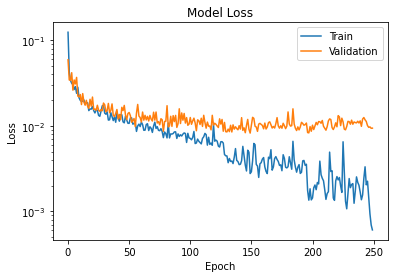

In [23]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('../Models/NNVoxelsLossCurve.png')
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

#Logistic Regression Doesn't Acc
lr = MultiOutputClassifier(LogisticRegression(max_iter=4000), n_jobs=-1)

columns2 = y_train.T.loc[y_train.nunique()==2].index
columns1 = y_train.T.loc[y_train.nunique()==1].index
y_train[columns2]


lr.fit(x_train, y_train[columns2])

MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=4000,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                      n_jobs=-1)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = pd.DataFrame(lr.predict(x_train), columns = columns2)
for i in columns1:
  y_pred[i] = y_train[i].mean()

print(accuracy_score(np.array(y_pred*1).flatten(), np.array(y_train*1).flatten()))
print(precision_score(np.array(y_pred*1).flatten(), np.array(y_train*1).flatten()))
print(recall_score(np.array(y_pred*1).flatten(), np.array(y_train*1).flatten()))

0.7143254695717506
0.1395678715266344
0.13970689442838619


In [19]:
y_pred = pd.DataFrame(lr.predict(x_val), columns = columns2)

for i in columns1:
  y_pred[i] = y_train[i].mean()

print(accuracy_score(np.array(y_pred*1).flatten(), np.array(y_val*1).flatten()))
print(precision_score(np.array(y_pred*1).flatten(), np.array(y_val*1).flatten()))
print(recall_score(np.array(y_pred*1).flatten(), np.array(y_val*1).flatten()))

0.7161640871525169
0.13810304295768477
0.13809850594810058


In [20]:
y_pred = pd.DataFrame(lr.predict(x_test), columns = columns2)

for i in columns1:
  y_pred[i] = y_train[i].mean()

print(accuracy_score(np.array(y_pred*1).flatten(), np.array(y_test*1).flatten()))
print(precision_score(np.array(y_pred*1).flatten(), np.array(y_test*1).flatten()))
print(recall_score(np.array(y_pred*1).flatten(), np.array(y_test*1).flatten()))

0.7140054094665665
0.1398792682331544
0.13984513666219622
